
# 01 – Precision-Recall Curves

**Module:** Anomaly & Fraud Detection  
**Topic:** Evaluation Metrics for Rare Events

This notebook demonstrates how to use **precision-recall curves** (PR curves)
to evaluate models on rare-event datasets, such as fraud detection.
PR curves are preferred over ROC curves when positive events are extremely rare.


## Objective

Build a leakage-free workflow that:
- Computes precision-recall curves and PR-AUC
- Visualizes trade-offs for different thresholds
- Supports threshold selection based on business priorities
- Works with probabilistic outputs from any classifier


## Design Principles

✔ Evaluate on real data distribution  
✔ Use probabilistic outputs rather than binary predictions  
✔ Visualize trade-offs clearly  
✔ Support threshold selection for rare-event recall


## High-Level Workflow

Trained Model  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Predict Probabilities on Validation/Test  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Compute Precision & Recall  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Plot PR Curve & Compute PR-AUC  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Evaluate Thresholds and Business Metrics


## Imports and Setup



In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, classification_report, auc

np.random.seed(2010)


## Dataset Assumptions

- Binary fraud target: `fraud`  
- Extreme class imbalance (~1–2% fraud)  
- Tabular numeric features

## Simulated Imbalanced Fraud Dataset



In [12]:
X, y = make_classification(
    n_samples=12000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    weights=[0.985, 0.015],
    flip_y=0.001,
    random_state=42
)

df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
df["fraud"] = y

## Leakage-Free Train / Test Split


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns="fraud"), df["fraud"],
    test_size=0.3, stratify=df["fraud"], random_state=42
)

## Train Baseline Model


In [19]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

## Predict Probabilities on Test Set


In [22]:
y_probs = model.predict_proba(X_test)[:,1]

## Compute Precision-Recall Curve and PR-AUC


In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

PR-AUC: 0.0495


## Plot PR Curve


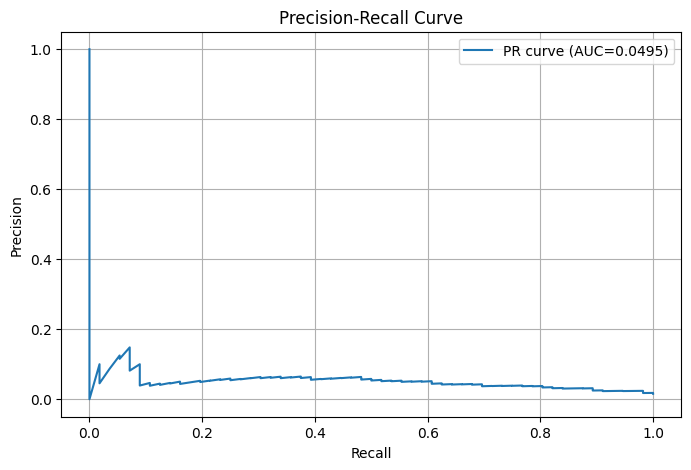

In [28]:
plt.figure(figsize=(8,5))
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

 ##  Threshold Selection
### Example: choose threshold that maximizes F1 score



In [31]:
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Optimal threshold (max F1): {best_threshold:.3f}")

Optimal threshold (max F1): 0.727


# Apply threshold


In [34]:
y_pred_adjusted = (y_probs >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3544
           1       0.06      0.48      0.11        56

    accuracy                           0.88      3600
   macro avg       0.53      0.69      0.52      3600
weighted avg       0.98      0.88      0.92      3600




## Interpretation

- PR curve emphasizes **minority class performance**
- Allows tuning threshold based on business cost of false negatives
- PR-AUC is a better metric than ROC-AUC in rare-event datasets


## Risks and Anti-Patterns

❌ Using ROC curves alone  
❌ Selecting thresholds on the test set (leakage)  
❌ Ignoring precision-recall trade-offs in deployment


## Production Checklist

✔ Train/test split leakage-free  
✔ Probabilistic outputs calibrated  
✔ PR curves used for thresholding and monitoring  
✔ Business metric alignment checked


## Key Takeaways

- PR curves are essential for rare-event evaluation
- Threshold tuning enables risk-sensitive deployment
- Always evaluate on real distribution to avoid overestimation of performance


## Next Steps

- Apply PR curve analysis to models trained with SMOTE, class weighting, or focal loss  
- Monitor PR-AUC drift over time  
- Integrate PR curves into alerting pipelines